# **Assessing the Diagnostic Accuracy of ML Algorithms for Identification of Asthma**

## Project Content <a id = 0></a>

### First Step: First Organization

1. [Introduction](#1)
2. [Loading The Relevant Libraries and Packages](#2)

### Second Step: Data Preprocessing

3. [](#3)
4. [](#4)
5. [](#5)

### Third and Final Step: Learning and Evaluation

6. [](#6)
7. [](#7)
8. [](#8)
9. [](#9)

***

# First Step: First Organization

***

## 1. Introduction <a id = 1></a>

### Project Overview

text

### Data Description

text

[Project Content](#0)

## 2. Loading The Relevant Libraries and Packages <a id = 2></a>

In [75]:
# Import necessary libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import scikit-learn modules
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, auc)

from sklearn.utils import resample

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score

import xgboost as xgb

import shap
shap.initjs()

[Project Content](#0)

***

# Second Step: Data Preprocessing

***

## 3. Loading and Preprocessing the dataset <a id = 3></a>

In [6]:
# Load the raw data from the CSV file into a pandas DataFrame
raw_data = pd.read_csv("data.csv")

# Print the shape of the dataset to provide information about its dimensions
print(f"The dataset shape is: {raw_data.shape}")

# Display the first 5 rows of the dataset to give an overview of its contents
raw_data.head(5)

The dataset shape is: (9254, 132)


,seqn,slq310,slq300,whd010,whd050,whd020,mcq010new,mcq053new,mcq092new,mcq160anew,...,ds2tmfat,ds2tpfat,ds2tlyco,ds2tlz,ds2tvc,ds2tzinc,ds2tsodi,ds2tpota,ds2tsele,ds2tcaff
0,93703,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,93704,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,93705,7:00,23:00,63.0,165.0,165.0,1.0,2.0,2.0,1.0,...,NaN,NaN,300.0,250.0,730.0,17.48,NaN,80.0,24.1,NaN
3,93706,10:00,23:30,68.0,145.0,145.0,2.0,2.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,93707,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Drop the 'seqn' column from the raw_data DataFrame, which contains the patients' IDs.
raw_data = raw_data.drop("seqn", axis=1)

raw_data.head(5)

,slq310,slq300,whd010,whd050,whd020,mcq010new,mcq053new,mcq092new,mcq160anew,mcq160nnew,...,ds2tmfat,ds2tpfat,ds2tlyco,ds2tlz,ds2tvc,ds2tzinc,ds2tsodi,ds2tpota,ds2tsele,ds2tcaff
0,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7:00,23:00,63.0,165.0,165.0,1.0,2.0,2.0,1.0,2.0,...,NaN,NaN,300.0,250.0,730.0,17.48,NaN,80.0,24.1,NaN
3,10:00,23:30,68.0,145.0,145.0,2.0,2.0,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Iterate over the specified columns to drop the minute part of datetime values and convert them to integers.
for col in ["slq310", "slq300"]:
    
    # Iterate over each row in the raw_data DataFrame
    for idx, rec in raw_data.iterrows():
    
        # Check if the value in the current row and column is "." (indicating missing data)
        if rec[col] == '.':
    
            # If the value is ".", set it to NaN (missing value) using .loc accessor
            raw_data.loc[idx, col] = float("Nan")
    
        # Check if the value in the current row and column is a string and not equal to "."
        elif type(rec[col]) == str and rec[col] != '.':
          
            # Split the value by ":" and take the first part (hour part), then convert it to an integer
            raw_data.loc[idx, col] = int(rec[col].split(':')[0])
            
raw_data[["slq310", "slq300"]].head(10)

,slq310,slq300
0,NaN,NaN
1,NaN,NaN
2,7,23
3,10,23
4,NaN,NaN
5,6,22
6,5,22
7,NaN,NaN
8,5,22
9,7,23


[Project Content](#0)

## 4. Imputing the Missing Values and Handling the Categorical Features<a id = 4></a>

In [9]:
def impute_missing_values(df, num_neighbors):
    """
    Impute missing values in the DataFrame using KNNImputer.

    Args:
    - df (DataFrame): Input DataFrame containing missing values.
    - num_neighbors (int): Number of nearest neighbors to consider.

    Returns:
    - DataFrame: DataFrame with missing values imputed.
    """
    
    # Create a KNNImputer object with the specified number of neighbors and distance-based weighting
    imputer = KNNImputer(n_neighbors=num_neighbors, weights="distance")
    
    # Fit the imputer to the DataFrame and transform the missing values
    imputed = imputer.fit_transform(df)
    
    # Create a new DataFrame with the imputed values and original column names
    imputed_data = pd.DataFrame(imputed, columns=df.columns)
    
    # Return the DataFrame with missing values imputed
    return imputed_data

In [10]:
def extract_int_cols(df):
    """
    Extract columns with integer values from the DataFrame.

    Args:
    - df (DataFrame): Input DataFrame.

    Returns:
    - list: List of column names containing integer values.
    """
    
    # Initialize an empty list to store column names with integer values
    int_cols = []
    
    # Get the column names of the DataFrame
    columns = df.columns
    
    # Iterate through each column in the DataFrame
    for col in columns:
        # Initialize a flag to track if all values in the column are integers
        is_int = True
        
        # Iterate over each value in the column
        for item in df[col]:
            # Check if the value is not NaN and if it's not equal to its integer representation
            if (not math.isnan(item)) and (float(int(item)) != float(item)):
                # If the value is not an integer, set the flag to False
                is_int = False
                # No need to continue checking the rest of the values in the column
                break
        
        # If all values in the column are integers
        if is_int:
            # Add the column name to the list of integer columns
            int_cols.append(col)
    
    # Return the list of column names containing integer values
    return int_cols

In [11]:
def handle_int_columns(df, int_columns):
    """
    Handle integer columns in the DataFrame.

    Args:
    - df (DataFrame): Input DataFrame.
    - int_columns (list): List of column names containing integer values.

    Returns:
    - DataFrame: DataFrame with integer columns handled.
    """
    
    # Round values in integer columns to the nearest integer
    for col in int_columns:
        df[col] = df[col].apply(lambda x: round(x))
    
    # Handle a specific column (mcq010new) by setting its values to 0 if equal to 2, otherwise set to 1
    df["mcq010new"] = df["mcq010new"].apply(lambda x: 0 if x == 2 else 1)
    
    # Return the DataFrame with integer columns handled
    return df

In [12]:
# Impute missing values in the raw data using KNNImputer
imputed_data = impute_missing_values(df=raw_data, num_neighbors=10)

# Extract columns with integer values from the imputed data
int_columns = extract_int_cols(df=imputed_data)

# Round values in integer columns and handle specific column "mcq010new"
rounded_data = handle_int_columns(df=imputed_data, int_columns=int_columns)

[Project Content](#0)

## 5. Upsampling and Splitting the Data<a id = 5></a>

In [13]:
def up_sampler(df):
    """
    Upsample minority class in the DataFrame.

    Args:
    - df (DataFrame): Input DataFrame.

    Returns:
    - DataFrame: DataFrame with upsampled minority class.
    """
    
    # Create two different DataFrames of majority and minority class
    df_majority = df[df["mcq010new"] == 0]
    df_minority = df[df["mcq010new"] == 1]
    
    # Upsample minority class
    df_minority_upsampled = resample(df_minority,
                                     replace=True,
                                     n_samples=len(df[df["mcq010new"] == 0]),
                                     random_state=42)
    
    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_minority_upsampled, df_majority])
    
    # Return the DataFrame with upsampled minority class
    return df_upsampled

In [14]:
# Split the rounded data into training and test sets, and ensure that the proportion of target variable classes is maintained using stratification
train_data, test_data = train_test_split(rounded_data, test_size=0.2, stratify=rounded_data["mcq010new"], random_state=42)

In [15]:
# Upsample the training data to address class imbalance
upsampled_train_data = up_sampler(train_data)

[Project Content](#0)

## 6. Training the Models and Checking their Performance<a id = 6></a>

In [16]:
def trainer(model, upsampled_train_data, test_data):
    """
    Train the model, make predictions, and evaluate performance.

    Args:
    - model: Machine learning model object.
    - upsampled_train_data (DataFrame): Upsampled training data.
    - Test_data (DataFrame): Test data for evaluation.

    Returns:
    - None
    """
    
    # Separate features and target variable for upsampled training data
    X_train_upsampled = upsampled_train_data.drop("mcq010new", axis=1)
    y_train_upsampled = upsampled_train_data["mcq010new"]

    # Separate features and target variable for test data
    X_test = test_data.drop("mcq010new", axis=1)
    y_test = test_data["mcq010new"]

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_upsampled)
    X_test_scaled = scaler.transform(X_test)

    # Train the model
    model.fit(X_train_scaled, y_train_upsampled)

    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)

    # Calculate ROC AUC
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_scores = model.decision_function(X_test_scaled)

    roc_auc = roc_auc_score(y_test, y_scores)

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = {:.2f})".format(roc_auc))
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()

    # Print the results
    print(f"Accuracy on Test Data: {accuracy * 100:.2f}%")
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", classification_rep)
    print(f"ROC AUC on Test Data: {roc_auc:.2f}")

### Support Vector Machine

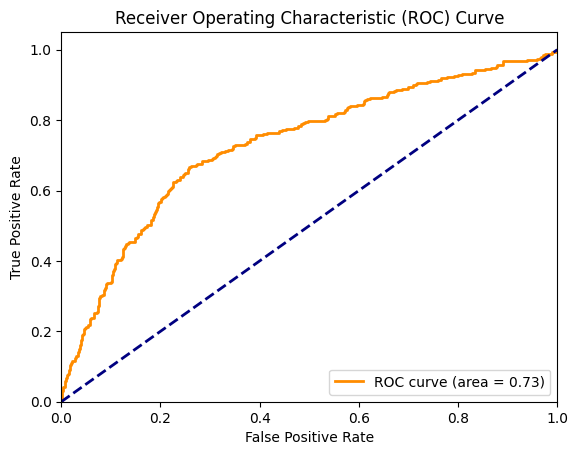

Accuracy on Test Data: 72.88%
Confusion Matrix:
 [[1146  399]
 [ 103  203]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.74      0.82      1545
           1       0.34      0.66      0.45       306

    accuracy                           0.73      1851
   macro avg       0.63      0.70      0.63      1851
weighted avg       0.82      0.73      0.76      1851

ROC AUC on Test Data: 0.73


In [17]:
# Define a Support Vector Classifier (SVC) with a linear kernel and regularization parameter C=1
model = SVC(
    kernel="linear",
    C=1)

# Train the model using the upsampled training data and evaluate its performance on the test data
trainer(model=model, upsampled_train_data=upsampled_train_data, test_data=test_data)

### Random Forest

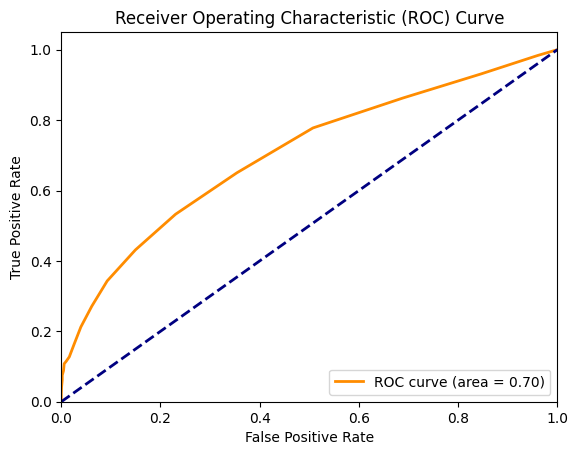

Accuracy on Test Data: 84.01%
Confusion Matrix:
 [[1505   40]
 [ 256   50]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.97      0.91      1545
           1       0.56      0.16      0.25       306

    accuracy                           0.84      1851
   macro avg       0.71      0.57      0.58      1851
weighted avg       0.81      0.84      0.80      1851

ROC AUC on Test Data: 0.70


In [18]:
# Define a Random Forest Classifier with 20 decision trees and random state set to 42
model = RandomForestClassifier(
    n_estimators=20,
    random_state=42)

# Train the model using the upsampled training data and evaluate its performance on the test data
trainer(model=model, upsampled_train_data=upsampled_train_data, test_data=test_data)

### K Nearest Neighbours

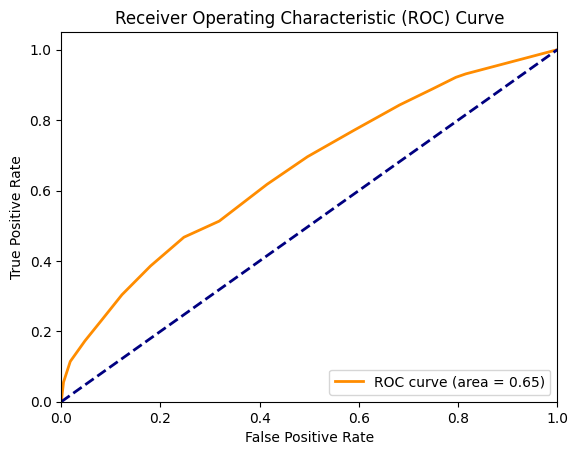

Accuracy on Test Data: 65.37%
Confusion Matrix:
 [[1053  492]
 [ 149  157]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.68      0.77      1545
           1       0.24      0.51      0.33       306

    accuracy                           0.65      1851
   macro avg       0.56      0.60      0.55      1851
weighted avg       0.77      0.65      0.69      1851

ROC AUC on Test Data: 0.65


In [19]:
# Define a K-Nearest Neighbors Classifier with 15 neighbors
model = KNeighborsClassifier(n_neighbors=15)

# Train the model using the upsampled training data and evaluate its performance on the test data
trainer(model=model, upsampled_train_data=upsampled_train_data, test_data=test_data)

### XGBoost

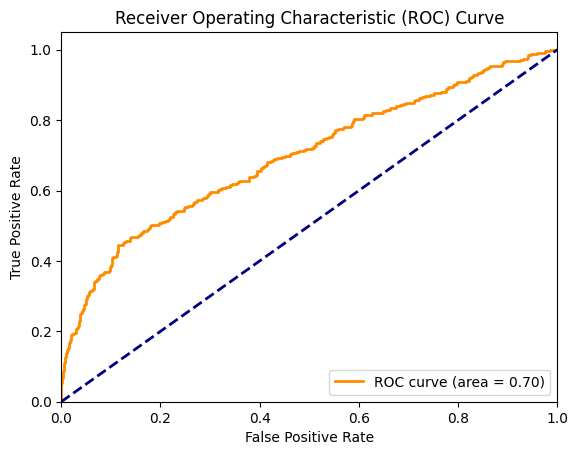

Accuracy on Test Data: 83.68%
Confusion Matrix:
 [[1453   92]
 [ 210   96]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.94      0.91      1545
           1       0.51      0.31      0.39       306

    accuracy                           0.84      1851
   macro avg       0.69      0.63      0.65      1851
weighted avg       0.81      0.84      0.82      1851

ROC AUC on Test Data: 0.70


In [20]:
# Define an XGBoost Classifier with binary logistic objective function,
# log loss evaluation metric, and disabling label encoder
model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss")

# Train the model using the upsampled training data and evaluate its performance on the test data
trainer(model=model, upsampled_train_data=upsampled_train_data, test_data=test_data)

### Ada Boost

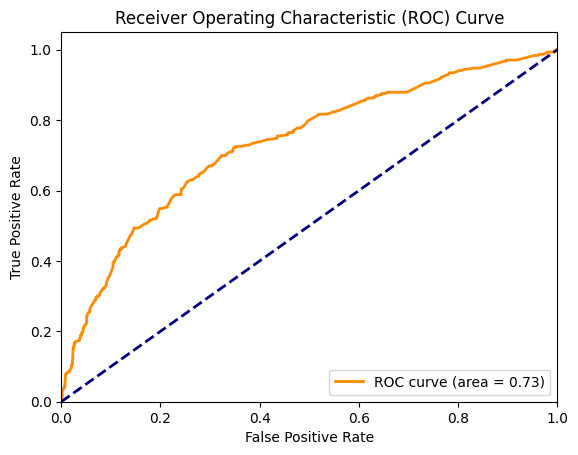

Accuracy on Test Data: 70.88%
Confusion Matrix:
 [[1116  429]
 [ 110  196]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.72      0.81      1545
           1       0.31      0.64      0.42       306

    accuracy                           0.71      1851
   macro avg       0.61      0.68      0.61      1851
weighted avg       0.81      0.71      0.74      1851

ROC AUC on Test Data: 0.73


In [21]:
# Define an AdaBoost Classifier with 15 base estimators and random state set to 42
model = AdaBoostClassifier(
    n_estimators=15,
    random_state=42
)

# Train the model using the upsampled training data and evaluate its performance on the test data
trainer(model=model, upsampled_train_data=upsampled_train_data, test_data=test_data)

### Naive Bayes

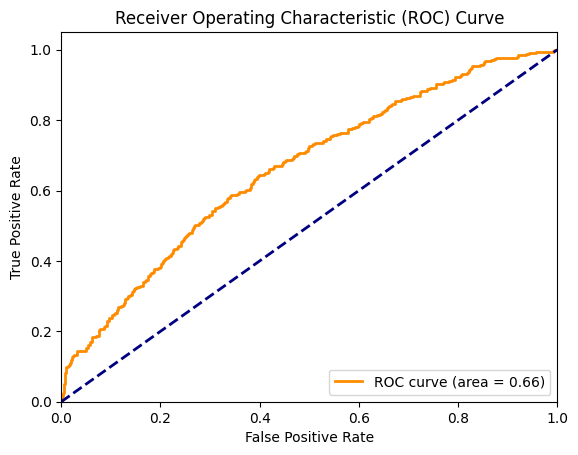

Accuracy on Test Data: 60.83%
Confusion Matrix:
 [[929 616]
 [109 197]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.60      0.72      1545
           1       0.24      0.64      0.35       306

    accuracy                           0.61      1851
   macro avg       0.57      0.62      0.54      1851
weighted avg       0.79      0.61      0.66      1851

ROC AUC on Test Data: 0.66


In [22]:
# Define a Bernoulli Naive Bayes Classifier
model = BernoulliNB()

# Train the model using the upsampled training data and evaluate its performance on the test data
trainer(model=model, upsampled_train_data=upsampled_train_data, test_data=test_data)

### Multi-layer Perceptron

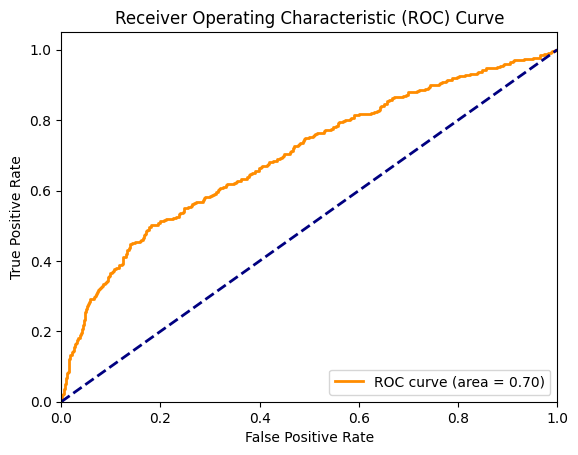

Accuracy on Test Data: 81.96%
Confusion Matrix:
 [[1417  128]
 [ 206  100]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.92      0.89      1545
           1       0.44      0.33      0.37       306

    accuracy                           0.82      1851
   macro avg       0.66      0.62      0.63      1851
weighted avg       0.80      0.82      0.81      1851

ROC AUC on Test Data: 0.70


In [23]:
# Define a Multi-layer Perceptron (MLP) Classifier with 2 hidden layers of sizes (1024, 2048), maximum iterations set to 1000, and random state set to 42
model = MLPClassifier(
    hidden_layer_sizes=(1024, 2048),
    max_iter=1000,
    random_state=42)

# Train the model using the upsampled training data and evaluate its performance on the test data
trainer(model=model, upsampled_train_data=upsampled_train_data, test_data=test_data)

[Project Content](#0)

## 7. Showing the Most Impactful Features in the Best Model's Prediction.<a id = 7></a>

In [24]:
# Define a Support Vector Classifier (SVC) with a linear kernel and regularization parameter C=1
model = SVC(
    kernel="linear",
    C=1,
    probability=True)

In [25]:
# Split the upsampled training data into features (X_train_upsampled) and target (y_train_upsampled)
X_train_upsampled = upsampled_train_data.drop("mcq010new", axis=1)
y_train_upsampled = upsampled_train_data["mcq010new"]

# Split the test data into features (X_test) and target (y_test)
X_test = test_data.drop("mcq010new", axis=1)
y_test = test_data["mcq010new"]

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_upsampled)
X_test_scaled = scaler.transform(X_test)

# Fit the model to the scaled training data
model.fit(X_train_scaled, y_train_upsampled);

In [26]:
# Create a DataFrame for the scaled features of the train data
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=train_data.drop("mcq010new", axis=1).columns)

# Display the first 5 rows of the DataFrame
X_train_scaled_df.head(5)

,slq310,slq300,whd010,whd050,whd020,mcq053new,mcq092new,mcq160anew,mcq160nnew,mcq160bnew,...,ds2tmfat,ds2tpfat,ds2tlyco,ds2tlz,ds2tvc,ds2tzinc,ds2tsodi,ds2tpota,ds2tsele,ds2tcaff
0,-0.324979,0.561416,-0.105516,-0.437325,-0.448849,0.223761,-3.359300,-1.981130,0.194501,-0.378994,...,1.769778,0.958059,-0.440953,0.815252,0.313717,1.652372,0.653680,0.112615,-0.411162,0.294079
1,1.704753,0.818038,-0.108581,-0.492889,-0.500040,-4.480361,0.301424,0.270268,0.194501,0.162620,...,0.698646,1.356059,-0.332442,1.245182,-0.137321,0.131877,-0.719928,-0.488036,0.302511,1.671599
2,-0.032594,0.164811,-0.102805,0.500618,0.484923,0.223761,0.301424,0.515649,0.194501,0.162620,...,-0.516426,-0.199048,0.227976,-0.169600,-0.189720,-0.650621,0.139961,-0.378577,-0.300863,-0.665942
3,1.197320,-2.004806,-0.102451,-0.363240,-0.393003,0.223761,0.301424,0.515649,0.194501,0.162620,...,-0.110571,-0.579861,-0.157910,2.296591,-0.183961,0.636321,-0.655569,-0.416285,0.157253,-0.549923
4,-0.324979,0.818038,-0.106537,-0.463255,-0.484217,-4.480361,0.301424,0.515649,0.194501,0.162620,...,0.058149,0.450018,-0.247725,-0.646171,-0.123620,0.922332,0.899660,0.515140,-1.052029,-0.164226


In [27]:
# Create a SHAP explainer object for the model using the scaled train data
explainer = shap.Explainer(model, X_train_scaled_df)

# Calculate SHAP values for the scaled train data
shap_values = explainer.shap_values(X_train_scaled_df)

In [28]:
# Calculate and display the average SHAP value for each column

shap_df = pd.DataFrame(shap_values, columns=X_train_scaled_df.columns)
average_shap_values = shap_df.abs().mean(axis=0)
print("Average for each column separately:\n")
average_shap_values.to_frame(name="Average Shap Value").sort_values(by="Average Shap Value", ascending=False).head(20)

Average for each column separately:



,Average Shap Value
mcq300bnew,0.690048
dr1ttfat,0.469902
mcq160knew,0.270286
ridagemn,0.262650
dr1tmfat,0.192072
ridageyr,0.167176
dr1tpfat,0.142796
dr1tsfat,0.125440
ridexagm,0.121501
bmxbmi,0.087329


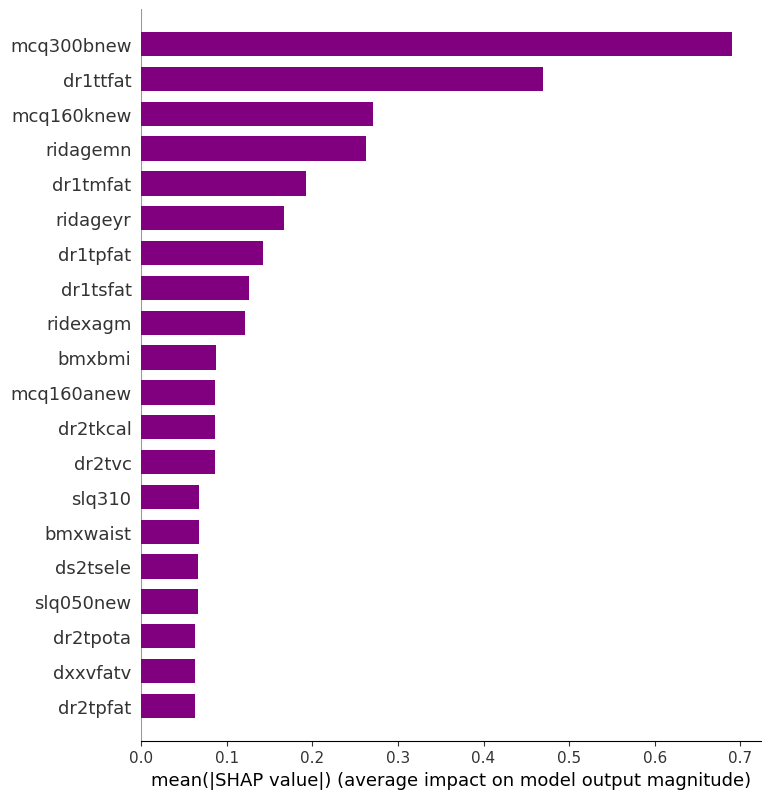

In [29]:
# Generate summary plot using SHAP values
shap.summary_plot(shap_values, X_train_scaled_df, plot_type="bar", color="purple", max_display=20)

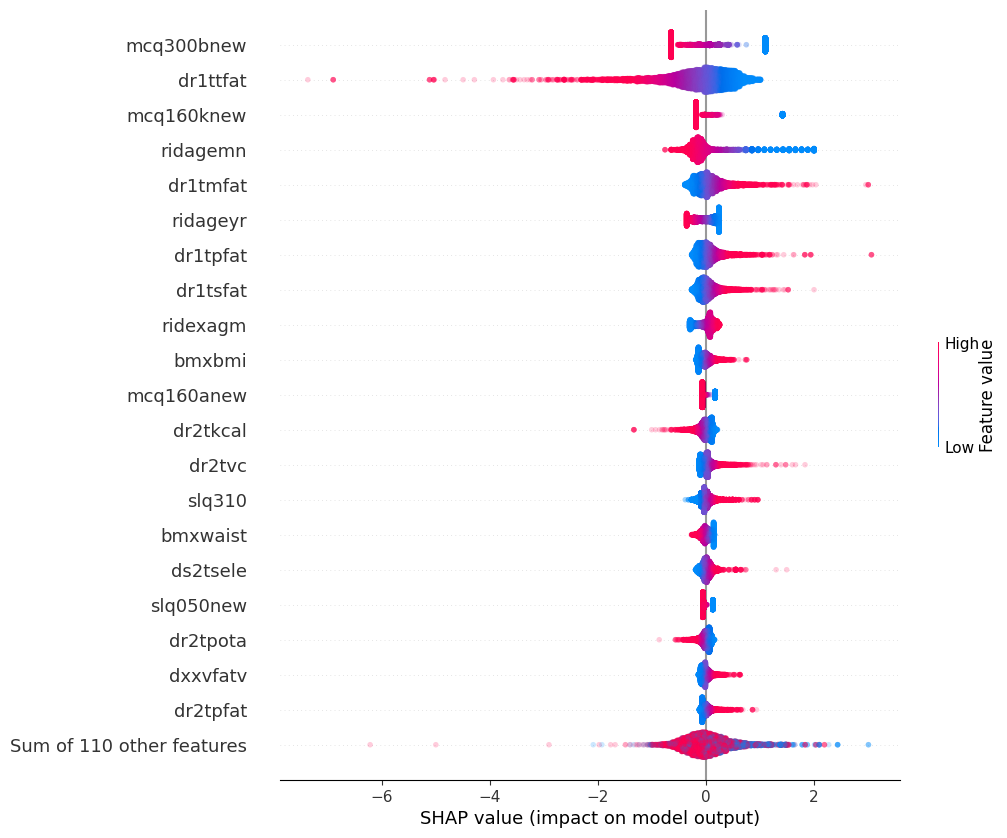

In [30]:
# Get the SHAP values
shap_values = explainer(X_train_scaled_df)

# Plot the beeswarm plot
shap.plots.beeswarm(shap_values, max_display=21, color_bar=True, alpha=0.2, plot_size=(10, 10))

In [31]:
shap_df_20 = shap_df[["mcq300bnew", "dr1ttfat", "mcq160knew", "ridagemn", "dr1tmfat", "ridageyr",
                      "dr1tpfat", "dr1tsfat", "ridexagm", "bmxbmi", "mcq160anew", "dr2tkcal",
                      "dr2tvc", "slq310", "bmxwaist", "ds2tsele", "slq050new", "dr2tpota",
                      "dxxvfatv", "dr2tpfat"]]

shap_df_20.head(5)

,mcq300bnew,dr1ttfat,mcq160knew,ridagemn,dr1tmfat,ridageyr,dr1tpfat,dr1tsfat,ridexagm,bmxbmi,mcq160anew,dr2tkcal,dr2tvc,slq310,bmxwaist,ds2tsele,slq050new,dr2tpota,dxxvfatv,dr2tpfat
0,-0.642513,-0.005705,-0.181957,-0.020594,0.015408,-0.355527,0.008237,-0.013087,0.200985,0.002214,0.169937,-0.022183,0.042155,-0.031140,-0.026337,-0.022515,-0.056945,-0.058997,0.052366,-0.002428
1,-0.642513,0.546589,0.009070,-0.199929,-0.219328,0.114727,-0.175192,-0.127524,0.196734,-0.110764,-0.043194,0.041774,-0.052988,0.202045,0.054748,0.044136,-0.056945,0.026561,-0.086692,-0.055743
2,0.068960,0.110213,-0.181957,-0.067202,-0.063095,0.234157,-0.084231,0.007358,-0.258336,-0.145732,-0.066424,0.115063,-0.111591,0.002451,0.143611,-0.012214,-0.039386,0.083813,-0.045546,-0.089881
3,0.214253,-0.094482,-0.181957,-0.212447,0.011916,0.099798,0.191254,-0.053143,0.240848,0.143168,-0.066424,-0.033713,-0.017342,0.143749,-0.127400,0.030570,0.128400,-0.061833,0.094892,0.035545
4,1.099100,-0.102387,-0.181957,-0.258393,0.044489,0.055012,0.031151,0.014055,0.145401,-0.108199,-0.066424,-0.043863,0.113374,-0.031140,0.062196,-0.082367,-0.056945,-0.021023,-0.105926,0.025012


In [32]:
df_20 = X_train_scaled_df[["mcq300bnew", "dr1ttfat", "mcq160knew", "ridagemn", "dr1tmfat", "ridageyr",
                      "dr1tpfat", "dr1tsfat", "ridexagm", "bmxbmi", "mcq160anew", "dr2tkcal",
                      "dr2tvc", "slq310", "bmxwaist", "ds2tsele", "slq050new", "dr2tpota",
                      "dxxvfatv", "dr2tpfat"]]

df_20.head(5)

,mcq300bnew,dr1ttfat,mcq160knew,ridagemn,dr1tmfat,ridageyr,dr1tpfat,dr1tsfat,ridexagm,bmxbmi,mcq160anew,dr2tkcal,dr2tvc,slq310,bmxwaist,ds2tsele,slq050new,dr2tpota,dxxvfatv,dr2tpfat
0,0.821509,-0.200240,0.295611,0.004185,-0.151215,1.862834,-0.160494,-0.249824,1.244361,0.146555,-1.981130,0.116057,0.129697,-0.324979,0.386646,-0.411162,0.596502,0.671111,0.680971,-0.077070
1,0.821509,-1.024918,-0.161308,0.406691,-1.000577,-0.622245,-1.014304,-0.885963,1.214784,-0.877914,0.270268,-0.424759,-0.588019,1.704753,-0.600294,0.302511,0.596502,-0.336465,-0.961592,-0.659374
2,-0.115061,-0.373327,0.295611,0.108794,-0.435270,-1.253377,-0.590906,-0.136172,-1.951610,-1.194998,0.515649,-1.044485,-1.030097,-0.032594,-1.681915,-0.300863,0.355101,-1.010705,-0.475573,-1.032227
3,-0.306321,-0.067680,0.295611,0.434785,-0.163852,-0.543354,0.691397,-0.472491,1.521730,1.424703,0.515649,0.213554,-0.319118,1.197320,1.616756,0.157253,-1.951674,0.704505,1.183286,0.337679
4,-1.471117,-0.055876,0.295611,0.537909,-0.045990,-0.306680,-0.053836,-0.098942,0.857604,-0.854655,0.515649,0.299380,0.666950,-0.324979,-0.690954,-1.052029,0.596502,0.223909,-1.188784,0.222631


[Project Content](#0)

## 8. Feature Reduction based on the SHAP Analysis<a id = 8></a>

### First 20 Features

In [52]:
# Delete the model variable
del model

# Define a Support Vector Classifier (SVC) with a linear kernel and regularization parameter C=1
model = SVC(
    kernel="linear",
    C=1,
    probability=True)

In [53]:
# Split the upsampled training data into features (X_train_upsampled) and target (y_train_upsampled)
X_train_upsampled = upsampled_train_data.drop("mcq010new", axis=1)
X_train_upsampled = X_train_upsampled[["mcq300bnew", "dr1ttfat", "mcq160knew", "ridagemn",
                                       "dr1tmfat", "ridageyr","dr1tpfat", "dr1tsfat", "ridexagm",
                                       "bmxbmi", "mcq160anew", "dr2tkcal", "dr2tvc", "slq310",
                                       "bmxwaist", "ds2tsele", "slq050new", "dr2tpota",
                                       "dxxvfatv", "dr2tpfat"]]

y_train_upsampled = upsampled_train_data["mcq010new"]

# Split the test data into features (X_test) and target (y_test)
X_test = test_data.drop("mcq010new", axis=1)
X_test = X_test[["mcq300bnew", "dr1ttfat", "mcq160knew", "ridagemn", "dr1tmfat", "ridageyr",
                 "dr1tpfat", "dr1tsfat", "ridexagm", "bmxbmi", "mcq160anew", "dr2tkcal", "dr2tvc",
                 "slq310", "bmxwaist", "ds2tsele", "slq050new", "dr2tpota", "dxxvfatv", "dr2tpfat"]]

y_test = test_data["mcq010new"]

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_upsampled)
X_test_scaled = scaler.transform(X_test)

# Fit the model to the scaled training data
model.fit(X_train_scaled, y_train_upsampled);

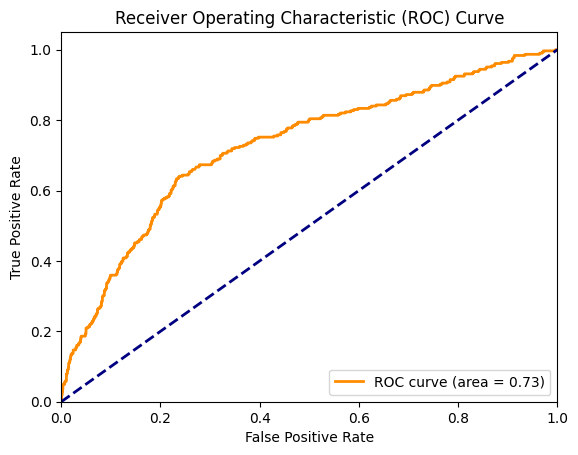

Accuracy on Test Data: 72.12%
Confusion Matrix:
 [[1133  412]
 [ 104  202]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.73      0.81      1545
           1       0.33      0.66      0.44       306

    accuracy                           0.72      1851
   macro avg       0.62      0.70      0.63      1851
weighted avg       0.82      0.72      0.75      1851

ROC AUC on Test Data: 0.73


In [54]:
# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Calculate ROC AUC
if hasattr(model, "predict_proba"):
    y_scores = model.predict_proba(X_test_scaled)[:, 1]
else:
    y_scores = model.decision_function(X_test_scaled)

roc_auc = roc_auc_score(y_test, y_scores)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = {:.2f})".format(roc_auc))
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# Print the results
print(f"Accuracy on Test Data: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)
print(f"ROC AUC on Test Data: {roc_auc:.2f}")

### First 10 Features

In [55]:
# Delete the model variable
del model

# Define a Support Vector Classifier (SVC) with a linear kernel and regularization parameter C=1
model = SVC(
    kernel="linear",
    C=1,
    probability=True)

In [56]:
# Split the upsampled training data into features (X_train_upsampled) and target (y_train_upsampled)
X_train_upsampled = upsampled_train_data.drop("mcq010new", axis=1)
X_train_upsampled = X_train_upsampled[["mcq300bnew", "dr1ttfat", "mcq160knew", "ridagemn",
                                       "dr1tmfat", "ridageyr","dr1tpfat", "dr1tsfat", "ridexagm",
                                       "bmxbmi"]]

y_train_upsampled = upsampled_train_data["mcq010new"]

# Split the test data into features (X_test) and target (y_test)
X_test = test_data.drop("mcq010new", axis=1)
X_test = X_test[["mcq300bnew", "dr1ttfat", "mcq160knew", "ridagemn", "dr1tmfat", "ridageyr",
                 "dr1tpfat", "dr1tsfat", "ridexagm", "bmxbmi"]]

y_test = test_data["mcq010new"]

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_upsampled)
X_test_scaled = scaler.transform(X_test)

# Fit the model to the scaled training data
model.fit(X_train_scaled, y_train_upsampled);

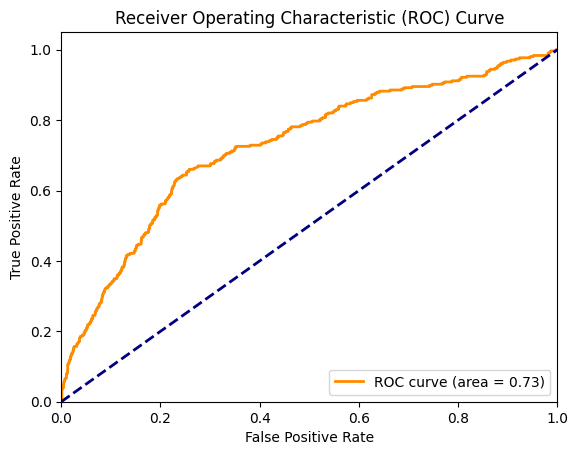

Accuracy on Test Data: 72.07%
Confusion Matrix:
 [[1131  414]
 [ 103  203]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.73      0.81      1545
           1       0.33      0.66      0.44       306

    accuracy                           0.72      1851
   macro avg       0.62      0.70      0.63      1851
weighted avg       0.82      0.72      0.75      1851

ROC AUC on Test Data: 0.73


In [57]:
# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Calculate ROC AUC
if hasattr(model, "predict_proba"):
    y_scores = model.predict_proba(X_test_scaled)[:, 1]
else:
    y_scores = model.decision_function(X_test_scaled)

roc_auc = roc_auc_score(y_test, y_scores)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = {:.2f})".format(roc_auc))
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# Print the results
print(f"Accuracy on Test Data: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)
print(f"ROC AUC on Test Data: {roc_auc:.2f}")

### First 3 Features

In [58]:
# Delete the model variable
del model

# Define a Support Vector Classifier (SVC) with a linear kernel and regularization parameter C=1
model = SVC(
    kernel="linear",
    C=1,
    probability=True)

In [59]:
# Split the upsampled training data into features (X_train_upsampled) and target (y_train_upsampled)
X_train_upsampled = upsampled_train_data.drop("mcq010new", axis=1)
X_train_upsampled = X_train_upsampled[["mcq300bnew", "dr1ttfat", "mcq160knew"]]

y_train_upsampled = upsampled_train_data["mcq010new"]

# Split the test data into features (X_test) and target (y_test)
X_test = test_data.drop("mcq010new", axis=1)
X_test = X_test[["mcq300bnew", "dr1ttfat", "mcq160knew"]]

y_test = test_data["mcq010new"]

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_upsampled)
X_test_scaled = scaler.transform(X_test)

# Fit the model to the scaled training data
model.fit(X_train_scaled, y_train_upsampled);

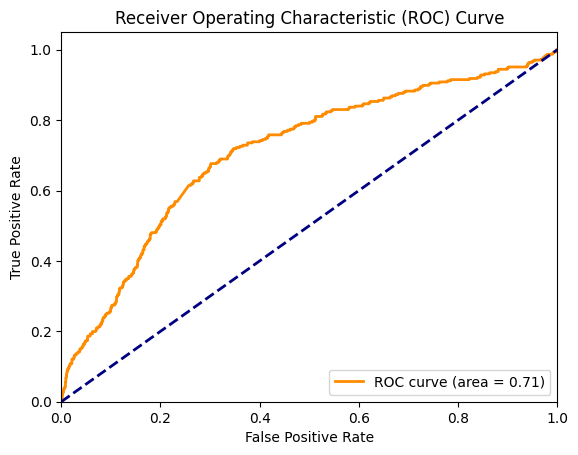

Accuracy on Test Data: 74.07%
Confusion Matrix:
 [[1201  344]
 [ 136  170]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.78      0.83      1545
           1       0.33      0.56      0.41       306

    accuracy                           0.74      1851
   macro avg       0.61      0.67      0.62      1851
weighted avg       0.80      0.74      0.76      1851

ROC AUC on Test Data: 0.71


In [60]:
# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Calculate ROC AUC
if hasattr(model, "predict_proba"):
    y_scores = model.predict_proba(X_test_scaled)[:, 1]
else:
    y_scores = model.decision_function(X_test_scaled)

roc_auc = roc_auc_score(y_test, y_scores)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = {:.2f})".format(roc_auc))
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# Print the results
print(f"Accuracy on Test Data: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)
print(f"ROC AUC on Test Data: {roc_auc:.2f}")

### First 1 Feature

In [61]:
# Delete the model variable
del model

# Define a Support Vector Classifier (SVC) with a linear kernel and regularization parameter C=1
model = SVC(
    kernel="linear",
    C=1,
    probability=True)

In [62]:
# Split the upsampled training data into features (X_train_upsampled) and target (y_train_upsampled)
X_train_upsampled = upsampled_train_data.drop("mcq010new", axis=1)
X_train_upsampled = X_train_upsampled[["mcq300bnew"]]

y_train_upsampled = upsampled_train_data["mcq010new"]

# Split the test data into features (X_test) and target (y_test)
X_test = test_data.drop("mcq010new", axis=1)
X_test = X_test[["mcq300bnew"]]

y_test = test_data["mcq010new"]

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_upsampled)
X_test_scaled = scaler.transform(X_test)

# Fit the model to the scaled training data
model.fit(X_train_scaled, y_train_upsampled);

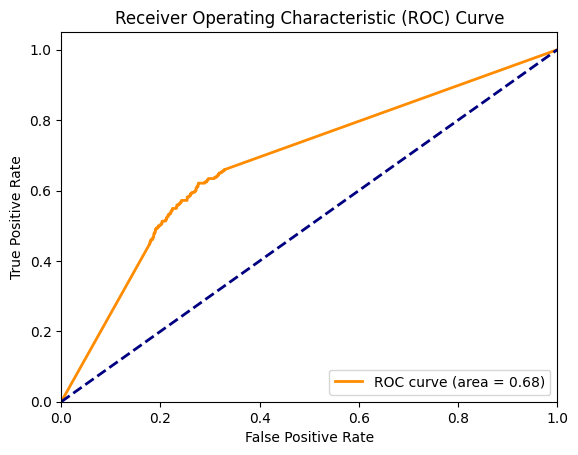

Accuracy on Test Data: 75.36%
Confusion Matrix:
 [[1242  303]
 [ 153  153]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.80      0.84      1545
           1       0.34      0.50      0.40       306

    accuracy                           0.75      1851
   macro avg       0.61      0.65      0.62      1851
weighted avg       0.80      0.75      0.77      1851

ROC AUC on Test Data: 0.68


In [63]:
# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Calculate ROC AUC
if hasattr(model, "predict_proba"):
    y_scores = model.predict_proba(X_test_scaled)[:, 1]
else:
    y_scores = model.decision_function(X_test_scaled)

roc_auc = roc_auc_score(y_test, y_scores)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = {:.2f})".format(roc_auc))
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# Print the results
print(f"Accuracy on Test Data: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)
print(f"ROC AUC on Test Data: {roc_auc:.2f}")

[Project Content](#0)

## 9. Improve the Results using 5-fold Cross Validation<a id = 9></a>

In [76]:
def trainer(model, upsampled_train_data, test_data, cv=5):
    """
    Train the model, make predictions, and evaluate performance using cross-validation.

    Args:
    - model: Machine learning model object.
    - upsampled_train_data (DataFrame): Upsampled training data.
    - Test_data (DataFrame): Test data for evaluation.
    - cv (int, default=5): Number of folds for cross-validation.

    Returns:
    - None
    """
    
    # Separate features and target variable for upsampled training data
    X_train_upsampled = upsampled_train_data.drop("mcq010new", axis=1)
    y_train_upsampled = upsampled_train_data["mcq010new"]

    # Separate features and target variable for test data
    X_test = test_data.drop("mcq010new", axis=1)
    y_test = test_data["mcq010new"]

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_upsampled)
    X_test_scaled = scaler.transform(X_test)

    # Train the model using cross-validation
    scores = cross_val_score(model, X_train_scaled, y_train_upsampled, cv=cv, scoring='accuracy')
    print(f"Cross-Validation Accuracy: {scores.mean() * 100:.2f}% (±{scores.std() * 100:.2f}%)")

    # Fit the model on the full training set
    model.fit(X_train_scaled, y_train_upsampled)

    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)

    # Calculate ROC AUC
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_scores = model.decision_function(X_test_scaled)

    roc_auc = roc_auc_score(y_test, y_scores)

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = {:.2f})".format(roc_auc))
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()

    # Print the results
    print(f"Accuracy on Test Data: {accuracy * 100:.2f}%")
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", classification_rep)
    print(f"ROC AUC on Test Data: {roc_auc:.2f}")

Cross-Validation Accuracy: 70.03% (±0.60%)


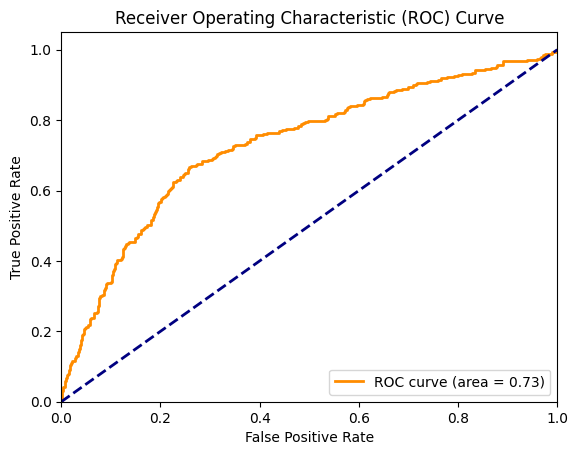

Accuracy on Test Data: 72.88%
Confusion Matrix:
 [[1146  399]
 [ 103  203]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.74      0.82      1545
           1       0.34      0.66      0.45       306

    accuracy                           0.73      1851
   macro avg       0.63      0.70      0.63      1851
weighted avg       0.82      0.73      0.76      1851

ROC AUC on Test Data: 0.73


In [78]:
# Define a Support Vector Classifier (SVC) with a linear kernel and regularization parameter C=1
model = SVC(
    kernel="linear",
    C=1)

# Train the model using the upsampled training data and evaluate its performance on the test data
trainer(model=model, upsampled_train_data=upsampled_train_data, test_data=test_data)

[Project Content](#0)